In [1]:
!python --version

Python 3.8.5


# Retrieve Information

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import glob
import re
import time

In [3]:
# Open the page source of the UTEP CS Faculty Page.
# Find all the classes that correspond to the faculty's information.
req = requests.get('https://www.utep.edu/cs/people/index.html')
soup = BeautifulSoup(req.text,'lxml')
divs = soup.findAll('div',{'class':'col-md-6'})

In [4]:
# Create a new directory in the current directory called 'professors'.
# Print a message to the user stating if the directory creation already exists, failed, or was successful.
path = os.path.join(os.getcwd(),'indexedFiles')
try:
    os.makedirs(path)
except FileExistsError:
    print ("The directory %s, already exists" % path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

The directory /Users/boo/Documents/3/assignment3/assignment3/indexedFiles, already exists


In [5]:
# Initialze lists to save the information from each professor.
names = []
titles = []
offices = []
emails = []
phones = []
websiteURLs = []

# Iterate through each of the faculty's information.
# If the faculty is a professor, add their information to the lists.
# If the faculty does not have a certain information (i.e. office), concatenate an empty list in order to keep the list indexes conistent.
for div in divs:
    # Save the faulcty's title if they are a professor.
    # If the faculty is a professor, retrieve the rest of their information.
    facultyTitle = div.find('span',{'class':'Title'})
    if facultyTitle is not None and "Professor" in facultyTitle.text:
        titles += [facultyTitle.text]
     
        # Save the professor's name.
        facultyName = div.find('h3',{'class':'name'})
        if facultyName is not None:
            names += [facultyName.text]
        else:
            names += []
    
        # Save the professor's office.
        facultyOffice = div.find("span", {"class":"address"})
        if facultyOffice is not None:
            offices += [facultyOffice.text]
        else:
            offices += []
        
        # Save the professor's email.
        facultyEmail = div.find('span',{'class':'email'})
        if facultyEmail is not None:
            emails += [facultyEmail.text.strip()]
        else:
            emails += []
            
        # Save the professor's phone.
        facultyPhone = div.find('span',{'class':'phone'})
        if facultyPhone is not None:
            phones += [facultyPhone.text.split('F')[0]]
        else:
            phones += []
    
        # Save the professor's website URL.
        facultyWebPage = div.findAll('a')
        if len(facultyWebPage) > 0:
            facultyURL = facultyWebPage[-1].get('href')
            websiteURLs += [facultyURL]
        else:
            websiteURLs += []
    
        # Save the contents of the professor's website if they have one.
        # Save the contents in a new file named with the professor's email.
        if len(facultyURL) > 0:
            webPageContent = requests.get(facultyURL)
            content = BeautifulSoup(webPageContent.text, 'lxml')

            tempPath = os.path.join(path,facultyEmail.text.split('@')[0]+'.txt')
            
            file = open(tempPath, "wt")
            file.write(content.text)
            file.close()

In [6]:
# Save the retrieved data into a dictionary.
# Create a dataframe for the retrieved information.
# Save the dataframe as a pickle file.
data = {'Name' : names, 'Title' : titles, 'Office' : offices, 'Email' : emails, 'Phone' : phones, 'Website' : websiteURLs}
professors = pd.DataFrame(data=data)
professors.to_pickle("professors.pkl")

# Preprocessing

In [7]:
from matchup.structure.vocabulary import Vocabulary
from matchup.structure.query import Query

In [8]:
# Creating the data structure that to store all the text.
vocabulary = Vocabulary('results',stopwords='stopWords/stopwords.txt')

# Import the folder path where all the professor's website contents are located. 
vocabulary.import_folder('indexedFiles')

# Generate the vocabulary data structure made up of the professor's websites.
# Save this stucture.
vocabulary.index_files()
vocabulary.save()

# Import the words that were just saved.
vocabulary.import_collection()

# Query processes a user query on the vocabulary collection we just created.
query = Query(vocabulary=vocabulary)

# Queries

**Query # 1:** improve student knowledge\*

* **Justification:** With this query, I want to retrieve all the professors that emphasize student improvement in their courses.
    

**Query # 2:** research collaboration cybersecurity models management

* **Justification:** With this query, I want to retrieve all the professors that do research in cybercesurity in collaboration with others and analyze resulting models.
 
 
**Query # 3:** fellowship honor awards earned recognition

* **Justification:** With this query, I want to retrieve all the professors who have received any sort of awards or recognition.
    
**Query # 4:** computation theory
    
* **Justification:** With this query, I want to retrieve all the professors whose work includes computation theory.

**Query # 5:** New York

* **Justification:** With this query, I want to retrieve all the professors who have lived in New York or received an education there.

**Query # 6:** pet cats

* **Justification:** With this query, I want to retrieve all the professors who have cats as pets.

**Query # 7:** human computer interaction

* **Justification:** With this query, I want to retrieve all the professors who work in human computer interaction.

**Query # 8:** middle school high school students

* **Justification:** With this query, I want to retrieve all the professors who do work that includes middle and high school students.

**Query # 9:** tenure

* **Justification:** With this query, I want to retrieve all the professors who are tenured.

**Query # 10:** software engineering design evolution advanced modeling

* **Justification:** With this query, I want to retrieve all the professors who work in the design, evolution, and modeling of software engineering.
    

In [9]:
# Retrieve queries from the queries.txt file.
queries = [i.rstrip() for i in open('queries.txt')]

# Running the queries using the models

In [10]:
# Importing the models.
from matchup.models.algorithms import Boolean
from matchup.models.algorithms import Vector
from matchup.models.algorithms import Probabilistic

In [11]:
# Initialize lists to save the information collected by the IR models.
# The information in these list is used to make a visualization.
profBool = []
profVect = []
profProb = []
queryBool = []
queryVect = []
queryProb = []
booleanScoreList = []
vectorScoreList = []
probabilisticScoreList = []
runningTimeBool = []
runningTimeVect = []
runningTimeProb = []


# Iterate through the list queries.
# Retrieve the results generated from each model on each query.
# Print these results.
for num,q in enumerate(queries):
    query.ask(answer=q)
    print('\033[1mResults for query {}: \033[0m{}'.format(num+1,q)) 
    
    #===================================
    # Boolean IR model
    #===================================
    
    # Keep track of the elapsed time to retrieve the results.
    startTime = time.time()
    booleanResults = query.search(model=Boolean())
    elapsedTime = time.time() - startTime
    
    # Convert the results to a list and remove the empty first element.
    resultsList = booleanResults.str_n(22).split("\n")
    resultsList.pop(0)
    
    print('\033[1mBoolean model:')
    print('\033[0m{} results found ({:.6f} sec)'.format(len(resultsList),elapsedTime))
    print()

    # Iterate through the results list and use the first dataframe created to access each professor's information.
    # The results are already ranked, so they can be printed directly.
    for i,prof in enumerate(resultsList):
        resultProf = prof.split(" ")
        # Use the professor's email to access the professor's row in the 'professors' dataframe.
        # Use this row to print the rest of the professor's information.
        value = professors[professors['Email'] == resultProf[0].split(".")[0]+"@utep.edu"].index[0]
        dfRow = professors.iloc[value]
        print('Rank #{}: {}'.format(i+1, resultProf[-1]))
        print(dfRow['Name'] + ', ' + dfRow['Title'])
        print('Office: ', dfRow['Office'], end = "  ")
        print('Email: ', dfRow['Email'], end = "  ")
        print('Phone: ', dfRow['Phone'])
        print('Website: ', dfRow['Website'])
        print()
        # Save the information to the lists initialized to create the visualization. 
        profBool += [dfRow['Name']]
        queryBool += [num+1]
        booleanScoreList += [resultProf[-1]]
        runningTimeBool += [elapsedTime]
        
    
    #===================================
    #        Vector-space IR model
    #===================================
      
    # Keep track of the elapsed time to retrieve the results.
    startTime = time.time()
    booleanResults = query.search(model=Vector())
    elapsedTime = time.time() - startTime
    
    resultsList = booleanResults.str_n(22).split("\n")
    resultsList.pop(0)
    
    print('\033[1mVector-space model:')
    print('\033[0m{} results found ({:.6f} sec)'.format(len(resultsList),elapsedTime))
    print()

    # Iterate through the results list and use the first dataframe created to access each professor's information.
    # The results are already ranked, so they can be printed directly.
    for i,prof in enumerate(resultsList):
        resultProf = prof.split(" ")
        # Use the professor's email to access the professor's row in the 'professors' dataframe.
        # Use this row to print the rest of the professor's information.
        value = professors[professors['Email'] == resultProf[0].split(".")[0]+"@utep.edu"].index[0]
        dfRow = professors.iloc[value]
        print('Rank #{}: {}'.format(i+1, resultProf[-1]))
        print(dfRow['Name'] + ', ' + dfRow['Title'])
        print('Office: ', dfRow['Office'], end = "  ")
        print('Email: ', dfRow['Email'], end = "  ")
        print('Phone: ', dfRow['Phone'])
        print('Website: ', dfRow['Website'])
        print()
        # Save the information to the lists initialized to create the visualization.
        profVect += [dfRow['Name']]
        queryVect += [num+1]
        vectorScoreList += [resultProf[-1]]
        runningTimeVect += [elapsedTime]
        
    #===================================
    #        Probabilistic IR model
    #===================================
    
    # Keep track of the elapsed time to retrieve the results.
    startTime = time.time()
    booleanResults = query.search(model=Probabilistic())
    elapsedTime = time.time() - startTime
    
    # Convert the results to a list and remove the empty first element.
    resultsList = booleanResults.str_n(22).split("\n")
    resultsList.pop(0)
    
    print('\033[1mProbabilistic model:')
    print('\033[0m{} results found ({:.6f} sec)'.format(len(resultsList),elapsedTime))
    print()

    # Iterate through the results list and use the first dataframe created to access each professor's information.
    # The results are already ranked, so they can be printed directly.
    for i,prof in enumerate(resultsList):
        resultProf = prof.split(" ")
        # Use the professor's email to access the professor's row in the 'professors' dataframe.
        # Use this row to print the rest of the professor's information.
        value = professors[professors['Email'] == resultProf[0].split(".")[0]+"@utep.edu"].index[0]
        dfRow = professors.iloc[value]
        print('Rank #{}: {}'.format(i+1, resultProf[-1]))
        print(dfRow['Name'] + ', ' + dfRow['Title'])
        print('Office: ', dfRow['Office'], end = "  ")
        print('Email: ', dfRow['Email'], end = "  ")
        print('Phone: ', dfRow['Phone'])
        print('Website: ', dfRow['Website'])
        print()
        # Save the information to the lists initialized to create the visualization.
        profProb += [dfRow['Name']]
        queryProb += [num+1]
        probabilisticScoreList += [resultProf[-1]]
        runningTimeProb += [elapsedTime]

Results for query 1: improve student knowledge
Boolean model:
13 results found (0.011988 sec)

Rank #1: 1.0
Natalia Villanueva-Rosales, Associate Professor
Office:  CCSB 3.0508  Email:  nvillanuevarosales@utep.edu  Phone:  (915)747-8643 
Website:  https://www.utep.edu/cs/people/nvillanuevarosales.html

Rank #2: 0.667
Vladik Kreinovich, Professor
Office:  CCSB 3.0404  Email:  vladik@utep.edu  Phone:  (915) 747-6951 
Website:  http://www.cs.utep.edu/vladik/

Rank #3: 0.667
Ann Q. Gates, Professor
Office:  Administration Building Room 310  Email:  agates@utep.edu  Phone:  (915) 747-7689 
Website:  http://www.cs.utep.edu/agates/

Rank #4: 0.667
Olac Fuentes, Professor
Office:  CCSB 3.0412  Email:  ofuentes@utep.edu  Phone:  (915) 747-6956 
Website:  https://www.utep.edu/cs/people/Fuentes.html

Rank #5: 0.667
Luc Longpré, Associate Professor  Undergraduate Program Director
Office:  CCSB 3.0420  Email:  longpre@utep.edu  Phone:  (915) 747-6804 
Website:  https://www.utep.edu/cs/people/longpr

Rank #18: 0.015
Nigel Ward, Professor
Office:  CCSB 3.0408  Email:  nigel@utep.edu  Phone:  (915) 747-6827 
Website:  http://www.cs.utep.edu/nigel/

Rank #19: 0.015
Shirley Moore, Associate Professor
Office:  TBD  Email:  svmoore@utep.edu  Phone:  (915) 747-5054 
Website:  http://www.cs.utep.edu/svmoore/

Rank #20: 0.015
Yoonsik Cheon, Associate Professor
Office:  CCSB 3.0606  Email:  ycheon@utep.edu  Phone:  (915) 747-8028 
Website:  http://www.cs.utep.edu/cheon/

Probabilistic model:
20 results found (0.004394 sec)

Rank #1: 1.478
Salamah I. Salamah, Associate Professor and Chair Director of Software Engineering
Office:  CCSB 3.1002  Email:  isalamah@utep.edu  Phone:  (915) 613-3110 
Website:  http://www.cs.utep.edu/isalamah/

Rank #2: 1.478
Saeid Tizpaz-Niari, Assistant Professor
Office:  CCSB 3.1006  Email:  saeid@utep.edu  Phone:  (915) 747-8408 
Website:  https://sites.google.com/a/colorado.edu/saeid-tizpaz-niari/

Rank #3: 1.28
Deepak Tosh, Assistant Professor
Office:  CCSB 3.10

Office:  CCSB 3.0418  Email:  cdkiekintveld@utep.edu  Phone:  (915) 747-5564 
Website:  http://www.cs.utep.edu/kiekintveld/

Rank #3: 0.426
Luc Longpré, Associate Professor  Undergraduate Program Director
Office:  CCSB 3.0420  Email:  longpre@utep.edu  Phone:  (915) 747-6804 
Website:  https://www.utep.edu/cs/people/longpre.html

Rank #4: 0.426
Deepak Tosh, Assistant Professor
Office:  CCSB 3.1010  Email:  dktosh@utep.edu  Phone:  (915) 747-6410  
Website:  http://www.cs.utep.edu/dktosh/

Rank #5: 0.426
Shirley Moore, Associate Professor
Office:  TBD  Email:  svmoore@utep.edu  Phone:  (915) 747-5054 
Website:  http://www.cs.utep.edu/svmoore/

Rank #6: 0.426
Vladik Kreinovich, Professor
Office:  CCSB 3.0404  Email:  vladik@utep.edu  Phone:  (915) 747-6951 
Website:  http://www.cs.utep.edu/vladik/

Probabilistic model:
6 results found (0.002076 sec)

Rank #1: 2.041
Christopher Kiekintveld, Associate Professor Graduate Program Director
Office:  CCSB 3.0418  Email:  cdkiekintveld@utep.edu 

Rank #19: 0.0
Vladik Kreinovich, Professor
Office:  CCSB 3.0404  Email:  vladik@utep.edu  Phone:  (915) 747-6951 
Website:  http://www.cs.utep.edu/vladik/

Rank #20: 0.0
Yoonsik Cheon, Associate Professor
Office:  CCSB 3.0606  Email:  ycheon@utep.edu  Phone:  (915) 747-8028 
Website:  http://www.cs.utep.edu/cheon/

Results for query 8: middle school high school students
Boolean model:
11 results found (0.003333 sec)

Rank #1: 1.0
Monika Akbar, Assistant Professor
Office:  CCSB 3.0422  Email:  makbar@utep.edu  Phone:  (915) 747-5883
Website:  http://www.cs.utep.edu/makbar/

Rank #2: 0.75
Saeid Tizpaz-Niari, Assistant Professor
Office:  CCSB 3.1006  Email:  saeid@utep.edu  Phone:  (915) 747-8408 
Website:  https://sites.google.com/a/colorado.edu/saeid-tizpaz-niari/

Rank #3: 0.75
Natalia Villanueva-Rosales, Associate Professor
Office:  CCSB 3.0508  Email:  nvillanuevarosales@utep.edu  Phone:  (915)747-8643 
Website:  https://www.utep.edu/cs/people/nvillanuevarosales.html

Rank #4: 0.75
E

# Visualization

In [12]:
# Import the necessary libraries for visualization.
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patch

In [13]:
# Create separate dataframes for each model.
# The dataframes will include the professor's name, the query, the score, and the running time. 
dfBool = pd.DataFrame({'Professor' : profBool, 'Query' : queryBool, 'Boolean Model Score' : booleanScoreList,'Boolean Model Running Time' : runningTimeBool})
dfVect = pd.DataFrame({'Professor' : profVect, 'Query' : queryVect, 'Vector-space Model Score' : vectorScoreList,'Vector-space Model Running Time' : runningTimeVect})
dfProb = pd.DataFrame({'Professor' : profProb, 'Query' : queryProb, 'Probabilistic Model Score' : probabilisticScoreList,'Probabilistic Model Running Time' : runningTimeProb})

In [14]:
# Merge all three dataframes to create a singular dataframe.
merged = pd.merge(dfBool,dfVect)
merged = pd.merge(merged,dfProb)

In [15]:
# Run this in order to have clearer graphs in jupyter notebook.
%config InlineBackend.figure_format = 'svg'

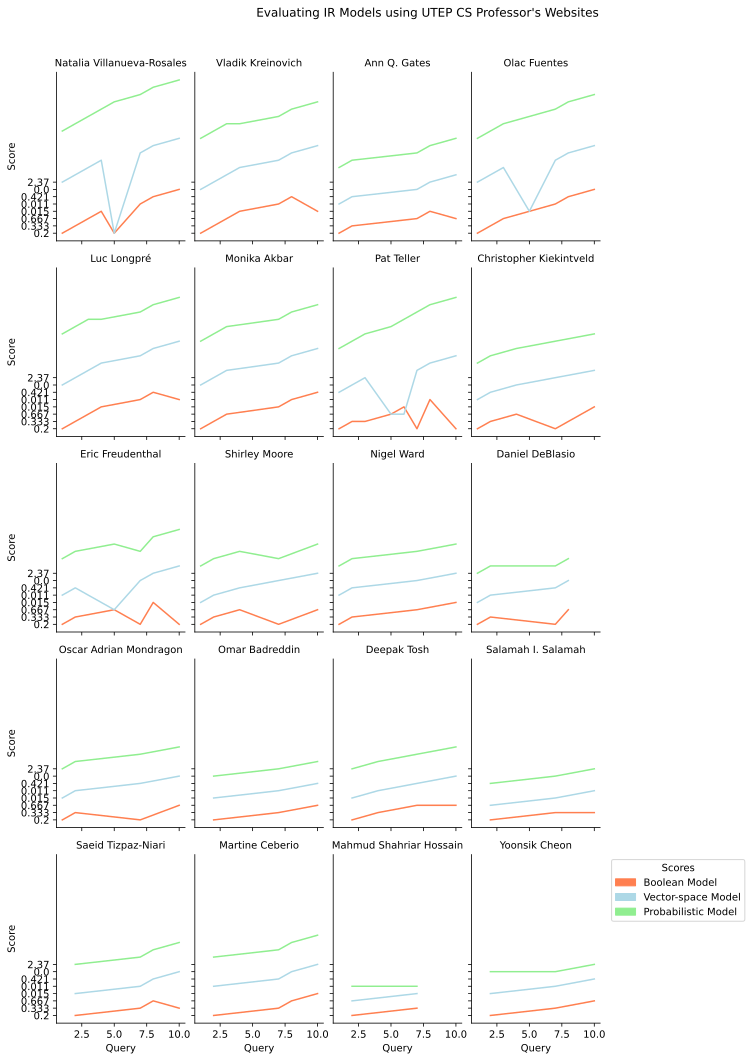

In [28]:
# Initialize a grid using the merged dataframe.
# This will be a graph with multiple scatterplots where each scatterplot corresponds to a professor.
# The horizontal axis will correspond to the query number.
# The vertical axis will correspond to the score the professor's website received by each model.
g = sns.FacetGrid(merged, col='Professor', hue='Professor', col_wrap=4)
 
# Add a line to each scatter plot using the scores each professor's website received for each query.
g = g.map(plt.plot, 'Query', 'Boolean Model Score', color='coral')
g = g.map(plt.plot, 'Query', 'Vector-space Model Score', color='lightblue')
g = g.map(plt.plot, 'Query', 'Probabilistic Model Score', color='lightgreen')

# Set the title of each indivdual scatterplot to the professor's name.
# Set the title of the horizontal axis to Query.
# Set the title of the vertical axis to Score.
g = g.set_titles("{col_name}")
g.set_axis_labels("Query", "Score")
 
# Add an overall title to the plot.
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle("Evaluating IR Models using UTEP CS Professor's Websites")

# Initialize a dictionary in order to manually create a legend.
name_to_color = {
    'Boolean Model':   'coral',
    'Vector-space Model':   'lightblue',
    'Probabilistic Model': 'lightgreen',
}

# Create a legend that will be displayed at the bottom right of the entire visualization.
patches = [patch.Patch(color=v, label=k) for k,v in name_to_color.items()]
plt.legend(handles=patches,title="Scores",loc='upper left',fancybox=True,bbox_to_anchor=(1.05, 1))

# Save the graph as "chart.png".
# Adjust the graph in order to ensure the legend is also saved to the file.
plt.subplots_adjust(right=0.7)
plt.savefig("chart.png", bbox_inches="tight")